# Interactive Data Miner
## ITD Advanced Analytics
- Date: 2018/05
- Credit: Based on MS TDSP Utilities

This notebook steps through the most common analyses performed in the early stages of the [CRISP DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) analysis process. The notebook is specifically centered around "Data Understanding" and covers basic "Data Preparation" tasks as well. 

More advanced data preparation and modeling work is use-case-specific and is not captured in this generic workflow. Rather, this notebook is intended to serve as a launchpad for more detailed analysis. 

In [1]:
from IPython.core.display import HTML
display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
    .widget-text { min-width: 60ex !important; }
</style>'''))

#Toggle Code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();

 } else {
 $('div.input').show();

 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);//commenting code disabling by default
</script>
<form action = "javascript:code_toggle()"><input type="submit" value="Toggle Raw Code"></form>''')

--------------------------------------------------------------------------

# <a name="setup"></a> 1.0 Global Configuration and Set Up

In [3]:
import collections

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from functools import partial
import IPython
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive,fixed
import operator
from IPython.display import Javascript, display,HTML, clear_output
from ipywidgets import widgets, VBox, Output, Layout
import seaborn as sns
from collections import OrderedDict
import yaml
import copy
import warnings
import getpass
import sys

warnings.filterwarnings('ignore')

from helpers import *
 
%matplotlib inline
font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')


## 1.1 Specify and load yaml file

In [185]:
import sys

#Read in yaml file as text
if (sys.version_info > (3, 0)):    
    yaml_file_name = input('Please enter yaml file Name: ')
else:
    yaml_file_name = raw_input('Please enter yaml file Name: ')

Sample_Size = 10000

# %%add_conf_code_to_report

conf_dict = ConfUtility.parse_yaml(yaml_file_name)

# Read in data from local file or SQL server
if 'DataSource' not in conf_dict:
    df=pd.read_csv(conf_dict['DataFilePath'], skipinitialspace=True)

# Making sure that we are not reading any extra column
df = df[[each for each in df.columns if 'Unnamed' not in each]]

# Filter out unnecessary columns
necessary_columns = conf_dict['CategoricalColumns'] + conf_dict['NumericalColumns'] + [conf_dict['Target']]
df = df[list(set(necessary_columns))]

# Save a backup of df and numerical columns, pre-manipulation
df_original = df
conf_dict['OriginalNumericalColumns'] = copy.deepcopy(conf_dict['NumericalColumns'])
conf_dict['OriginalCategoricalColumns'] = copy.deepcopy(conf_dict['CategoricalColumns'])

Please enter yaml file Name: data.yaml


--------------------------------------
# 2.0 Prepare Data
Section 2 covers typical data manipulation steps to prepare data for analysis. It is common to first run the full notebook, then evaluate features to identify outliers, non-normal distributions, etc. that are then remediated by coming back to section 2 for cleansing. 

After applying changes in any subsection of this section, be sure to hit the "Apply" buttons to re-compile the notebook with the changes you've made.

## 2.1 Filtering
Filters are applied in this first section such that any transformations of the data are reflected in analyses below. Note that changes made to the data in this section are not automatically propagated through the document, subsequent cells must be re-compiled individually with Ctrl+Enter or by selecting *Cell > Run All Below* (recommended).

In [155]:
# Use the qgrid library to generate an interactive filtering data table
import qgrid
qgrid_widget = qgrid.show_grid(df_original, grid_options = {'forceFitColumns': False}, show_toolbar = False)
#qgrid_widget_postproc = qgrid.show_grid(df0, grid_options = {'filterable':False, 'forceFitColumns': False}, show_toolbar = False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

The tool supports filtering on ranges. For more refined filtering methods (e.g. validating values against other columns), custom code can be added by expanding the source code and adding user-defined functions. Any custom function must produce a Pandas DataFrame object named 'df' to propagate through the notebook.

[[Hit "Toggle Raw Code" button at top of notebook to edit user-defined filters]]

In [ ]:
##################### Add user-defined filters here ############################
# Example: data['may_build_date'] = data[data['build_month'] == 5]

In [186]:
# Re-run all cells below
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

print("Confirm Filter Application")
button_rerun = widgets.Button(description="Apply")
button_rerun.on_click(run_all)
display(button_rerun)

<IPython.core.display.Javascript object>

Confirm Filter Application


Button(description='Apply', style=ButtonStyle())

## 2.2 Log Transformations
It may be necesarry to transform certain columns. In particular, it is common to log-transform numerical columns to ensure a normal distribution. If a feature fails the normality tests below, try creating a log-transformed version of that feature here- this version may pass a normality test.

Note: When a column is log-transformed, the original column (e.g. "Age") is replaced by the transformed version ("Age_log"). If you decide not to use the transformation, simply re-run this section with your column de-selected to restore the original version.

In [187]:
# Reset values
df_xform = qgrid_widget.get_changed_df()
conf_dict['NumericalColumns'] = copy.deepcopy(conf_dict['OriginalNumericalColumns'])
log_transforms = {}

# Define a multiple-select list to select columns for transformation
log_list = widgets.SelectMultiple(
    options=conf_dict['NumericalColumns'],
    description='Select Column(s)',
    disabled=False,
    layout=Layout(display="flex", flex_flow='column')
)

display(log_list)

# And a button to execute the transform
out_log = Output()
with out_log:
        clear_output()

def apply_log(ev):
    for feature in log_list.value:
        # Create new feature
        new_feature = feature + '_log'
        df_xform[new_feature] = np.log1p(df_xform[feature])
        conf_dict['NumericalColumns'].append(new_feature)
        # Drop untransformed feature
        conf_dict['NumericalColumns'].remove(feature)
        df_xform.drop([feature], axis = 1, inplace = True)
        log_transforms.update({new_feature: {'type': 'log1p', 'source_feature': feature}})
        with out_log: 
            print("Generated log transform of " + feature + ": " + new_feature)
            print("Removed " + feature + " from numerical features")

            


button_log = widgets.Button(description="Add Transforms")
button_log.on_click(apply_log)
display(button_log)

display(out_log)

SelectMultiple(description='Select Column(s)', layout=Layout(display='flex', flex_flow='column'), options=('Id…

Button(description='Add Transforms', style=ButtonStyle())

Output()

In [188]:
print("Apply log transforms to notebook")
display(button_rerun)

Apply log transforms to notebook


Button(description='Apply', style=ButtonStyle())

## 2.3 Discretization
In some cases, it may be beneficial to bin numerical values. This can be achieved in the following section. Binning will add columns with an appended *_bin* label.

In [189]:
df_binned = copy.deepcopy(df_xform)
conf_dict['CategoricalColumns'] = copy.deepcopy(conf_dict['OriginalCategoricalColumns'])

# Prep a clean-sheet output to reflect transforms being applied
out_disc = Output()
with out_disc:
        clear_output()

# Define a multiple-select list to select columns for transformation
feature_list = widgets.Dropdown(
    options=conf_dict['NumericalColumns'],
    description='Feature:'
)

bincount = widgets.IntSlider(
    min=2, max=100,
    step=1, value=4,
    description='Number of Bins')

display(feature_list)
display(bincount)



# Pre-allocate dict to log transformations
bin_transforms = {}

# And a button to execute the transform
def apply_bin(ev):
    # Create new feature
    feature = feature_list.value
    new_feature = feature + '_bin'
    # Create the binned feature
    df_binned[new_feature] = pd.qcut(df_binned[feature], bincount.value, duplicates = 'drop')
    # Add the feature 
    conf_dict['CategoricalColumns'].append(new_feature)
    with out_disc: 
        print("Generated binned version of " + feature + ": " + new_feature)
    # Update the log
    bin_transforms.update({new_feature: {'bin_count': bincount.value, 'source_feature': feature}})
            


button_bin = widgets.Button(description="Apply Discretization")
button_bin.on_click(apply_bin)
display(button_bin)

display(out_disc)

Dropdown(description='Feature:', options=('Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'Overal…

IntSlider(value=4, description='Number of Bins', min=2)

Button(description='Apply Discretization', style=ButtonStyle())

Output()

In [190]:
print("Apply binning to notebook")
display(button_rerun)

Apply binning to notebook


Button(description='Apply', style=ButtonStyle())

## 2.4 Export Transformations

The transformations specified in the sub-sections of section 2 are automatically exported to a YAML file for reproducibility. See "transformation_logs.yaml" in your working directory for a record of transformations.

In [191]:
transforms = {}


# Grab filters from the qgrid section
filter_definition = qgrid_widget.get_state()


for feature in filter_definition['_columns']:
    exp_feature = filter_definition['_columns'][feature]
    
    # Look for filtering flag for the feature
    if 'filter_info' in exp_feature:
        filter_info = exp_feature['filter_info']
        
        # Parse categorical feature filter
        if filter_info['type'] == 'text':
            values = exp_feature['values']
            # When exclude is empty, only include the included values
            if len(filter_info['excluded']) == 0:
                include_values = [values[i] for i in filter_info['selected']]
                transforms.update({feature: {'filter': {'type': 'categorical', 'filter_values': include_values}}})
                
            else:
                include_values = [values[i] for i in list(range(len(values))) if i not in filter_info['excluded']]
                transforms.update({feature: {'filter': {'type': 'categorical', 'filter_values': include_values}}})
            
        # Parse numerical feature filter
        if filter_info['type'] == 'slider':
            min_value = filter_info['min']
            max_value = filter_info['max']
            num_range = [filter_info['min'], filter_info['max']]
            transforms.update({feature: {'filter': {'type': 'numerical', 'filter_range': num_range}}})
            
            
            
# Get log transforms
for i in log_transforms:
    if i in transforms:
        transforms[i].update({'log': log_transforms[i]})
    else:
        transforms.update({i:{'log': log_transforms[i]}})



# Get binning transforms
for i in bin_transforms:
    if i in transforms:
        transforms[i].update({'discretize': bin_transforms[i]})
    else:
        transforms.update({i:{'discretize': bin_transforms[i]}})


# Sort by keys
transforms = dict(collections.OrderedDict(sorted(transforms.items())))

# Save transformations to yaml
with open('transformation_logs.yaml', 'w') as outfile:
    yaml.dump(transforms, outfile, default_flow_style=False)
    
print("Exported transformation log to ./transformation_logs.yaml")
print("\n=========================== \nTransformation Log: ")
print(transforms)

Exported transformation log to ./transformation_logs.yaml

Transformation Log: 
{}


---------------------------------------

# 3.0 Summaries

In [192]:
# Sampling Data if data size is larger than 10k
df0 = df_binned # df0 is the unsampled data. Will be used in data exploration and analysis where sampling is not needed
         # However, keep in mind that your final report will always be based on the sampled data. 
    

if Sample_Size < df_binned.shape[0]:
    df = df_binned.sample(Sample_Size)
else:
    df = df_binned

# change float data types
if 'FloatDataTypes' in conf_dict:   
    for col_name in conf_dict['FloatDataTypes']:
        df[col_name] = df[col_name].astype(float)      
        
# Getting the list of categorical columns if it was not there in the yaml file
if 'CategoricalColumns' not in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(list(df.select_dtypes(exclude=[np.number]).columns)))

# Getting the list of numerical columns if it was not there in the yaml file
if 'NumericalColumns' not in conf_dict:
    conf_dict['NumericalColumns'] = list(df.select_dtypes(include=[np.number]).columns)    

# Exclude columns that we do not need
if 'ColumnsToExclude' in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(conf_dict['CategoricalColumns'])-set(conf_dict['ColumnsToExclude']))
    conf_dict['NumericalColumns'] = list(set(conf_dict['NumericalColumns'])-set(conf_dict['ColumnsToExclude']))

# Ordering the categorical variables according to the number of unique categories
filtered_cat_columns = []
temp_dict = {}
for cat_var in conf_dict['CategoricalColumns']:
    temp_dict[cat_var] = len(np.unique(df[cat_var].dropna()))
sorted_x = sorted(temp_dict.items(), key=operator.itemgetter(0), reverse=True)
conf_dict['CategoricalColumns'] = [x for (x,y) in sorted_x]

ConfUtility.dict_to_htmllist(conf_dict,['Target','CategoricalColumns','NumericalColumns'])

## 3.1 Review Post-Processed Data

In [193]:
qgrid_widget_postproc = qgrid.show_grid(df0, grid_options = {'filterable':False, 'forceFitColumns': False}, show_toolbar = False)
qgrid_widget_postproc

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## 3.2 Dimensions

In [194]:
print ('The data has {} Rows and {} columns'.format(df0.shape[0],df0.shape[1]))

The data has 1460 Rows and 81 columns


## 3.3 Print the column types

In [195]:
print("The types of columns are:")
df.dtypes

The types of columns are:


HouseStyle       object
LotArea           int64
YearRemodAdd      int64
Foundation       object
ExterCond        object
BsmtUnfSF         int64
1stFlrSF          int64
PoolArea          int64
MiscVal           int64
BsmtExposure     object
GarageFinish     object
GarageCond       object
GarageArea        int64
WoodDeckSF        int64
Condition1       object
Electrical       object
Utilities        object
GarageQual       object
BsmtFullBath      int64
MoSold            int64
BldgType         object
KitchenQual      object
LotShape         object
Fence            object
BsmtFinSF1        int64
GarageCars        int64
TotRmsAbvGrd      int64
MSZoning         object
CentralAir       object
SalePrice         int64
                 ...   
RoofMatl         object
LotFrontage     float64
HalfBath          int64
MasVnrArea      float64
Fireplaces        int64
FullBath          int64
YearBuilt         int64
BsmtCond         object
KitchenAbvGr      int64
BsmtFinSF2        int64
LotConfig       

##  3.4 Extract Descriptive Statistics of Each Column

In [196]:
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x.dropna()))


temp_df = df0.describe().T

sum_df = pd.DataFrame(df0.sum(numeric_only = True))
sum_df.columns = ['sum']

missing_df = pd.DataFrame(df0.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']

unq_df = pd.DataFrame(df0.apply(num_unique, axis=0))
unq_df.columns = ['unique']

types_df = pd.DataFrame(df0.dtypes)
types_df.columns = ['DataType']

### 3.4.1 Numerical Columns:

In [197]:
summary_df = temp_df.join(sum_df).join(missing_df).join(unq_df).join(types_df).drop_duplicates()
summary_df

,count,mean,std,min,25%,50%,75%,max,sum,missing,unique,DataType
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0,15354569.0,0,1073,int64
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0,2897904.0,0,61,int64
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0,828171.0,0,780,int64
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0,1697435.0,0,753,int64
PoolArea,1460.0,2.758904,40.177307,0.0,0.00,0.0,0.00,738.0,4028.0,0,8,int64
MiscVal,1460.0,43.489041,496.123024,0.0,0.00,0.0,0.00,15500.0,63494.0,0,21,int64
GarageArea,1460.0,472.980137,213.804841,0.0,334.50,480.0,576.00,1418.0,690551.0,0,441,int64
WoodDeckSF,1460.0,94.244521,125.338794,0.0,0.00,0.0,168.00,857.0,137597.0,0,274,int64
BsmtFullBath,1460.0,0.425342,0.518911,0.0,0.00,0.0,1.00,3.0,621.0,0,4,int64
MoSold,1460.0,6.321918,2.703626,1.0,5.00,6.0,8.00,12.0,9230.0,0,12,int64


### 3.4.2 Categorical Columns:

In [198]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in conf_dict['CategoricalColumns']:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

,missing,unique,DataType
HouseStyle,0,8,object
Foundation,0,6,object
ExterCond,0,5,object
BsmtExposure,38,4,object
GarageFinish,81,3,object
GarageCond,81,5,object
Condition1,0,9,object
Electrical,1,5,object
Utilities,0,2,object
GarageQual,81,5,object


-----------------------------------------------

# 4.0 Explore Individual Variables

## 4.1 Explore the target variable

In [225]:
def histPlot(data, target):
    plt.hist(data[target])
    plt.show()

interact(histPlot,
        data=fixed(df),
        target=widgets.Dropdown(
            options=conf_dict['NumericalColumns'],
            value=conf_dict['Target'],
            description='Target:',
            disabled=False,
        ))

interactive(children=(Dropdown(description='Target:', index=37, options=('Id', 'MSSubClass', 'LotFrontage', 'L…

<function __main__.histPlot(data, target)>

## 4.2 Numeric Variable Summaries & Normality Tests
The following plots provide summary visualizations for numerical features. 

Along the top row of charts, we see a histogram and density plot of the distribution. 

The bottom-left chart shows a QQ-Plot: For a normal distribution, the blue points will generally fall on the red diagonal line. In addition, a normality test is run and results are printed at the top (p<0.05 = not normal, p>=0.05 is normal).

Finally, the bottom-right chart shows a boxplot of the feature. Note that black circles are statistical outliers, it may be worth considering filtering these values in the filtering section at the top of this notebook.

In [202]:
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
        options=conf_dict['NumericalColumns'],
        value=conf_dict['NumericalColumns'][0],
        description='Numeric Variable:',
    )

interact(NumericAnalytics.custom_barplot, df=fixed(df), col1=w1)

interactive(children=(Dropdown(description='Numeric Variable:', options=('Id', 'MSSubClass', 'LotFrontage', 'L…

<function helpers.NumericAnalytics.custom_barplot(df, col1='')>

## 4.3 Categorical Variable Summaries

In [203]:
w1_value = ''
w1 = None

w1 = widgets.Dropdown(
    options = conf_dict['CategoricalColumns'],
    value = conf_dict['CategoricalColumns'][0],
    description = 'Categorical Variable:',
)

interact(CategoricAnalytics.custom_barplot, df=fixed(df), col1=w1)


interactive(children=(Dropdown(description='Categorical Variable:', options=('Utilities', 'Street', 'SaleType'…

<function helpers.CategoricAnalytics.custom_barplot(df, col1='')>

##  4.4 Interactions Between Variables

###  4.4.1 Rank variables based on linear relationships with reference variable
In this section, we review the relationships between numeric and categorical variables against a reference variable (likely your target). This is a quick way to understand which features may contribute to the predictive value of a model.

In [204]:
cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] + conf_dict['CategoricalColumns'] 
cols_list = list(OrderedDict.fromkeys(cols_list)) 
w1 = widgets.Dropdown(    
    options=cols_list,
    value=cols_list[0],
    description='Ref Var:'
)
w2 = ipywidgets.Text(value="5", description='Top Num Vars:')
w3 = ipywidgets.Text(value="5", description='Top Cat Vars:')

interact(InteractionAnalytics.rank_associations, df=fixed(df),conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3)


interactive(children=(Dropdown(description='Ref Var:', options=('SalePrice', 'Id', 'MSSubClass', 'LotFrontage'…

<function helpers.InteractionAnalytics.rank_associations(df, conf_dict, col1, col2, col3)>

###  4.4.2 Interactions between categorical variables

In [205]:
w1, w2 = None, None

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['CategoricalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Categorical Var 2:'
)

interact(InteractionAnalytics.categorical_relations, df=fixed(df), col1=w1, col2=w2)


interactive(children=(Dropdown(description='Categorical Var 1:', options=('Utilities', 'Street', 'SaleType', '…

<function helpers.InteractionAnalytics.categorical_relations(df, col1, col2)>

###  4.4.4 Interactions between numerical variables

In [207]:
w1, w2 = None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['NumericalColumns']
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Numerical Var 2:'
)

interact(InteractionAnalytics.numerical_relations, df=fixed(df), col1=w1, col2=w2)


interactive(children=(Dropdown(description='Numerical Var 1:', options=('SalePrice', 'Id', 'MSSubClass', 'LotF…

<function helpers.InteractionAnalytics.numerical_relations(df, col1, col2)>

### 4.4.5 Correlation matrix between numerical variables
The correlation matrix represents the results of mass correlation analyses between all numerical variables. A value of 1 represents a perfect correlation, while 0 indicates no correlation. 

The matrix can use multiple correlation methods. Some guidelines for selecting the correct method are below. For continuous features we have:

* Pearson: Most widely used method, measures degree of association. Variables must be linear and normally distributed and must be continuous (e.g. age, weight).

When incorporating rank data, use one of the following:

* Spearman: Similar to Pearson, but no assumption of normal distribution and the variables can be either continuous or ordinal (e.g. finishing position in a race, rank in class). This is the more popular rank metric over Kendall.
* Kendall: More robust than Spearman when working with small datasets, or datasets with errors. This robustness comes with a tradeoff on performance, with Kendall being exponentially slower for large datasets.


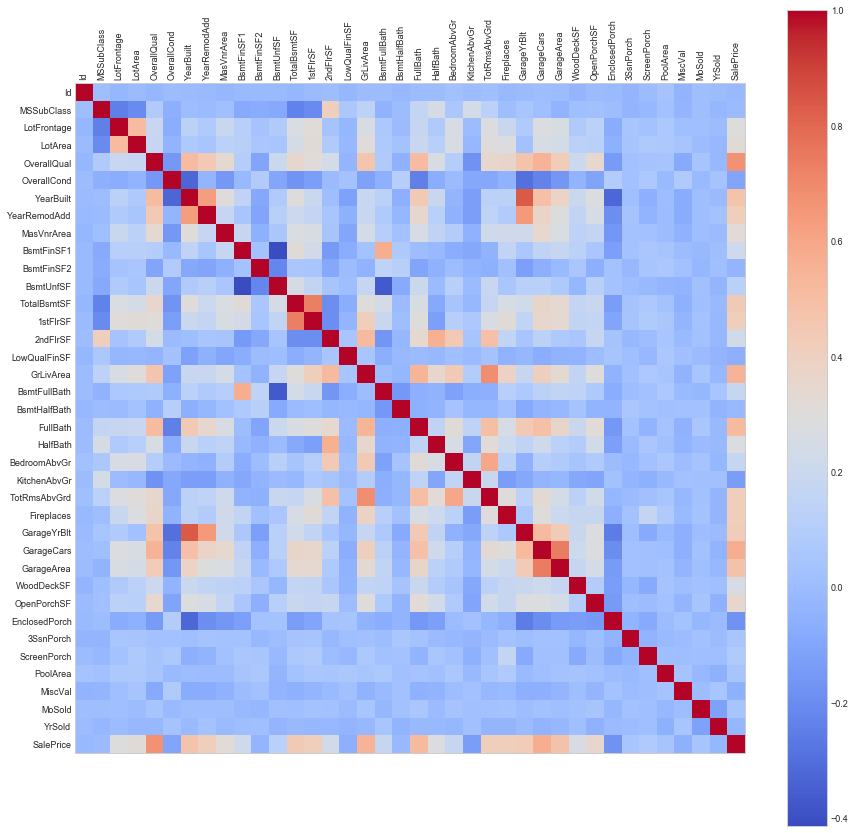

In [247]:
from matplotlib.pyplot import quiver, colorbar, clim,  matshow
import matplotlib.ticker as ticker

df2 = df[conf_dict['NumericalColumns']].corr(method='kendall')
col_names = list(df[conf_dict['NumericalColumns']].columns)

fig,ax = plt.subplots(figsize=(15,15))
m = ax.matshow(df2, cmap=matplotlib.pyplot.cm.coolwarm)
ax.grid(b=False)
fig.colorbar(m)
ax.set_xticklabels([' '] + col_names, rotation=90)
ax.set_yticklabels([' '] + col_names)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
fig.show()

###  4.4.6 Interactions between numerical and categorical variables
In this section we perform hypothesis tests to determine whether the values of a categorical variable (e.g. your target) have statistically different distributions. Note that a p-value is calculated to reflect one of two interpretations:

* p<=0.05: We reject the null hypothesis that the different levels of the categorical variable are equal. In other words, the levels are significantly different. 
* p>0.05: Accept the null hypothesis that the levels of the categorical feature are equal. There is no difference in the value of the numerical feature between our categories.

In [209]:
w1, w2 = None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Variable:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Variable:'
)
interact(InteractionAnalytics.nc_relation, df=fixed(df),conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=fixed(w3))


interactive(children=(Dropdown(description='Numerical Variable:', options=('SalePrice', 'Id', 'MSSubClass', 'L…

<function helpers.InteractionAnalytics.nc_relation(df, conf_dict, col1, col2, col3=None)>

### 4.4.8 Interactions between two numerical and one categorical variable

In [211]:
w1, w2, w3 = None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[1],
    description = 'Numerical Var 2:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['CategoricalColumns']
    
w3 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Legend Cat Var:'
)
interact(InteractionAnalytics.nnc_relation, df=fixed(df),conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3)


interactive(children=(Dropdown(description='Numerical Var 1:', options=('SalePrice', 'Id', 'MSSubClass', 'LotF…

<function helpers.InteractionAnalytics.nnc_relation(df, conf_dict, col1, col2, col3)>

---------------------------------
# 5.0 Latent Trait Analysis & Dimension Reduction

## 5.1 Principal Components Analysis (PCA)
Principal component analysis re-calculates *n* principal components for a dataset with *n* numerical features. The principal components are derived sequentially to capture the largest amount of variation in the data, i.e. PC1 captures the most variation, followed by PC2, then PC3... Each principal component is a combination of the original features. 

Practically speaking, PCA is commonly used for two purposes: Dimension reduction and latent trait analysis. For the purposes of this workflow, we are interested in latent trait analysis. 

PCAs can often capture latent traits in our data in the same way an IQ test estimates intelligence (the latent trait) from questions (our numerical features). The variable factor compass shows how the original numerical features influence the "momentum" of points in our PCA scatterplot. For example, if we saw an "oil temperature" arrow pointing north-east on our compass, we would ascertain that points in the top right of our scatter plot have high oil temperatures, while points in the bottom left have lower oil temp. Furthermore, arrows that are close to eachother imply a relationship between those values. If our "oil temperature" vector points in a similar direction to "ambient temperature", a possible relationship between those values is implied. If the scatterplot shows many points flagged as "failures" in the top right, this points to a relationship between ambient temp, oil temp and failure.

The final chart shows the percentage of variation captured by each principal component. When drawing insights from PCA, it's important to make sure that these insights are based on a sufficient portion of the variation. For example, if PC1 captures 40% of variation and PC2 captures 35%, a scatterplot of PC1 and PC2 explains 75% of the variation and we can draw fairly robust conclusions. Conversely, if PC1 and PC2 only capture 5% of variation, conclusions are fairly disconnected from the complete dataset.

In [357]:
# Investigate missingness
# NA values will crash the model fits, so let's see how to handle them

## Function to count NAs
def count_NA(data):
    na_counts = data.isnull().sum(axis=0).reset_index(name='NACount')
    ## Print out the list of columns with missing values
    return(na_counts[na_counts.NACount>0].sort_values('NACount', ascending=False))

def FillNACols(data, colname, value):
    data[colname][data[colname].isna()] = value
    return(data)

# Inspect NA counts
## Get the counts of NAs
na_counts = count_NA(df)
## Print details about each column with NAs
for idx in na_counts['index']:
    print('Feature: {}'.format(idx))
    print('Number of NAs: {}'.format(na_counts.NACount[na_counts['index']==idx].item()))
    print(df[idx].unique())
    print('==============================================')

# Fill values
## Simple fills
df = FillNACols(df, 'PoolQC', 'None')
df = FillNACols(df, 'MiscFeature', 'None')
df = FillNACols(df, 'Fence', 'None')
df = FillNACols(df, 'FireplaceQu', 'None')
df = FillNACols(df, 'GarageFinish', 'None')
df = FillNACols(df, 'GarageCond', 'None')
df = FillNACols(df, 'GarageQual', 'None')
df = FillNACols(df, 'GarageType', 'None')
df = FillNACols(df, 'BsmtExposure', 'None')
df = FillNACols(df, 'BsmtQual', 'None')
df = FillNACols(df, 'BsmtCond', 'None')
df = FillNACols(df, 'BsmtFinType1', 'None')
df = FillNACols(df, 'BsmtFinType2', 'None')

## Remove Rows
df = df = df[pd.notna(df['MasVnrType'])]
df = df = df[pd.notna(df['Electrical'])]

## Remove Columns
cols_to_drop = ['GarageYrBlt', 'LotFrontage']
try:
    df.drop(columns=cols_to_drop, inplace=True)
except:
    print("Columns already dropped")

Columns already dropped


In [364]:
# Update conf_dict to reflect the new df
conf_dict['CategoricalColumns'] = list(set(conf_dict['CategoricalColumns']) - set(cols_to_drop))
conf_dict['NumericalColumns'] = list(set(conf_dict['NumericalColumns']) - set(cols_to_drop))

In [376]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def numerical_pca_egv(df, conf_dict, col1, col2, col3):
    # Do the PCA.
    n_components = len(conf_dict['NumericalColumns'])
    df2 = df[conf_dict['NumericalColumns']]

    scaler = StandardScaler()
    scaler.fit(df2)
    df2 = scaler.transform(df2)
    df2 = pd.DataFrame(df2, columns = conf_dict['NumericalColumns'])

    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(df2)
    print(pca.explained_variance_ratio_)

    # Append the principle components for each entry to the dataframe
    for i in range(0, n_components):
        df2['PC' + str(i + 1)] = reduced[:, i]

    #display(df2.head())
    if col1 not in conf_dict['NumericalColumns']:
        df.reset_index(drop=True, inplace=True)
        df2.reset_index(drop=True, inplace=True)
        df2[col1] = df[col1]

    # Show the points in terms of the first two PCs
    g = sns.lmplot(('PC' + str(col2)),
                   ('PC' + str(col3)),
                   hue=col1,
                   data=df2,
                   fit_reg=False,
                   scatter=True,
                   size=7)
    plt.show()

    # Plot a variable factor map for the first two dimensions.
    (fig, ax) = plt.subplots(figsize=(8, 8))
    for i in range(0, len(pca.components_)):
        ax.arrow(0,
                 0,  # Start the arrow at the origin
                 pca.components_[int(col2) - 1, i],  #0 for PC1
                 pca.components_[int(col3) - 1, i],  #1 for PC2
                 head_width=0.05,
                 head_length=0.08)

        plt.text(pca.components_[int(col2) - 1, i] + 0.05,
                 pca.components_[int(col3) - 1, i] + 0.05,
                 df2.columns.values[i])

    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')
    ax.set_title('Variable factor compass')
    plt.show()

    # Do a scree plot
    ind = np.arange(0, n_components)
    cumpca = np.cumsum(pca.explained_variance_ratio_)
    
    (fig, ax) = plt.subplots(figsize=(8, 6))
    sns.pointplot(x=ind, y=cumpca)
    ax.set_title('Scree plot')
    ax.set_xticks(ind)
    ax.set_xticklabels(ind)
    ax.set_xlabel('Component Number')
    ax.set_ylabel('Explained Variance')
    plt.show()
    

num_numeric = len(conf_dict['NumericalColumns'])
if  num_numeric > 3:
    
    w1, w2, w3 = None, None, None
    if conf_dict['Target'] in conf_dict['CategoricalColumns']:
        cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] 
        cols_list = list(OrderedDict.fromkeys(cols_list)) 
    else:
        cols_list = conf_dict['CategoricalColumns']

    
    w1 = widgets.Dropdown(
        options = cols_list,
        value = cols_list[0],
        description = 'Legend Variable:',
        width = 10
    )
    w2 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '1',
        width = 1,
        description='PC at X-Axis:'
    )
    w3 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '2',
        description = 'PC at Y-Axis:'
    )
    
    interact(numerical_pca_egv, \
             df=fixed(df), \
             conf_dict= fixed(conf_dict), \
             col1=w1, col2=w2, col3=w3)

interactive(children=(Dropdown(description='Legend Variable:', options=('HouseStyle', 'Foundation', 'ExterCond…

-------------------------------------------

# 6.0 Save Transformed Dataset

In [213]:
# Define download function
js_download = """
                var csv = '%s';

                var filename = 'results.csv';
                var blob = new Blob([csv], { type: 'text/csv;charset=utf-8;' });
                if (navigator.msSaveBlob) { // IE 10+
                    navigator.msSaveBlob(blob, filename);
                } else {
                    var link = document.createElement("a");
                    if (link.download !== undefined) { // feature detection
                        // Browsers that support HTML5 download attribute
                        var url = URL.createObjectURL(blob);
                        link.setAttribute("href", url);
                        link.setAttribute("download", filename);
                        link.style.visibility = 'hidden';
                        document.body.appendChild(link);
                        link.click();
                        document.body.removeChild(link);
                    }
                }
                """ % df0.to_csv(index=False).replace('\n','\\n').replace("'","\'")

# Run JS on button click
def download_csv(sink):
    display(Javascript(js_download))


print("Download the processed dataset to CSV:")
button_dl = widgets.Button(description="Download")
button_dl.on_click(download_csv)
display(button_dl)

Download the processed dataset to CSV:


Button(description='Download', style=ButtonStyle())